In [1]:
# package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# scikit learn!
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import cdist

# umap for dimensionality reduction
import umap

# nice plotting
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# cleaned aryl X dataset
# We kept parameters for the low energy conformer (removing those for min/max and Bolztmann average, which are highly correlated)
arylx = pd.read_csv('arylx.csv')
arylx.head()

,id,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,ω_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,...,%Vbur_Br_2.5Å_low_E,%Vbur_C_3.0Å_low_E,%Vbur_Br_3.0Å_low_E,%Vbur_C_3.5Å_low_E,%Vbur_Br_3.5Å_low_E,%Vbur_C_4.0Å_low_E,%Vbur_Br_4.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,arbr141,Cc1[nH]nc(C(F)(F)F)c1Br,-0.30770,0.01581,0.32351,-0.145945,0.03292,43.1852,89.2019,5.5518,...,34.132048,78.811271,33.014563,68.080856,31.508572,56.128189,29.409255,2.277507,4.841637,4.126049
1,arbr142,Cc1[nH]nc(-c2ccccc2)c1Br,-0.27821,0.00248,0.28069,-0.137865,0.03386,102.7150,147.4390,2.8706,...,36.231931,77.875447,34.498845,67.397153,32.274390,55.776721,29.634644,2.077762,7.508006,4.136710
2,arbr143,Cc1cc(C(C)(C)C)cc(C)c1Br,-0.28384,0.01480,0.29864,-0.134520,0.03030,86.5084,162.0250,1.8175,...,36.599818,79.910980,35.651631,70.185543,33.763511,58.853811,30.847713,2.968765,4.479852,4.170312
3,arbr145,Cc1cccc(Cl)c1Br,-0.30209,-0.00082,0.30127,-0.151455,0.03807,69.3040,110.6700,2.6224,...,36.397968,79.426773,35.005401,69.397596,32.937127,57.807554,30.127708,1.868018,4.498470,4.153900
4,arbr146,Cc1cccc(F)c1Br,-0.30220,0.00107,0.30327,-0.150565,0.03738,62.0065,98.2669,2.6395,...,34.662716,78.545888,33.005252,67.583512,30.757315,55.012104,27.829201,1.850000,4.454212,4.152511


In [3]:
# the molecular descriptors
X = arylx.select_dtypes(include=['number'])

# Feature scaling through standardization (or Z-score normalization) is an important preprocessing step 
# for many machine learning algorithms. Standardization involves rescaling the features such that they 
# have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. 

X_scaled=pd.DataFrame(scale(X),index=X.index, columns=X.columns)

# drop zero-variance features
zero_std_cols = X_scaled.columns[X_scaled.std() == 0]
X_scaled=X_scaled[X_scaled.columns.difference(zero_std_cols)]
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

# drop highly correlated features
corr = X_scaled.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_scaled = X_scaled.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 0 features Index([], dtype='object')
Dropping 10 features ['ω_low_E', 'SASA_surface_area(Å²)_low_E', 'SASA_volume(Å³)_low_E', 'pyramidalization_Gavrish_C(°)_low_E', '%Vbur_Br_2.5Å_low_E', '%Vbur_Br_3.0Å_low_E', '%Vbur_C_3.5Å_low_E', '%Vbur_Br_3.5Å_low_E', '%Vbur_C_4.0Å_low_E', '%Vbur_Br_4.0Å_low_E']


In [ ]:
X_scaled

,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,volume(Bohr_radius³/mol)_low_E,SASA_sphericity_low_E,NBO_charge_Br_low_E,...,pyramidalization_Agranat-Radhakrishnan_C_low_E,NBO_LP_energy_Br_low_E,NBO_LP_occupancy_Br_low_E,%Vbur_C_2.0Å_low_E,%Vbur_Br_2.0Å_low_E,%Vbur_C_2.5Å_low_E,%Vbur_C_3.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,-0.662377,1.665360,2.231269,0.754691,-1.580527,-1.507738,1.917174,-0.849583,1.134697,1.356760,...,-0.454564,-0.504804,1.228426,-0.139160,0.656509,0.887520,1.480351,1.195502,-0.633773,-0.255286
1,0.926729,1.097343,0.371520,1.209931,0.167396,-0.007780,0.020707,0.195476,0.099138,0.096874,...,4.280327,0.431995,1.982498,-0.209054,2.074293,0.358087,1.058218,0.367962,1.087865,-0.207194
2,0.623350,1.622322,1.151120,1.398394,-0.308464,0.367897,-0.724172,1.000581,0.065236,-1.836176,...,-0.455547,1.391285,0.416792,0.210312,1.640756,1.057751,1.976409,4.059369,-0.867373,-0.055611
3,-0.360075,0.956723,1.265346,0.444249,-0.813622,-0.954804,-0.154850,-0.935549,1.543756,0.143812,...,-0.455256,0.428621,-0.656753,0.175364,1.879787,0.973416,1.757992,-0.501005,-0.855352,-0.129647
4,-0.366002,1.037260,1.352209,0.494393,-1.027893,-1.274259,-0.142755,-0.932373,1.707934,0.073014,...,-0.455552,0.387010,-0.037954,0.357090,1.036147,0.817241,1.360642,-0.575652,-0.883928,-0.135913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,1.553427,-0.225759,-1.482148,0.662855,1.681749,1.608798,-0.574008,1.571986,-0.834827,-0.873171,...,-0.427909,0.836853,0.431182,0.301174,-0.768305,-0.041721,-0.376192,1.356809,-0.098136,-0.098957
5042,1.173528,-0.352317,-1.304947,0.380583,3.030500,2.417950,-0.041254,1.698709,-1.589796,-0.864957,...,0.046985,0.978554,0.311740,0.329132,-0.794082,-0.052653,-0.389633,0.374397,1.062836,-0.101060
5043,0.679391,-0.310983,-0.864549,0.149583,1.680046,0.298511,0.382714,0.257995,0.003780,-0.812544,...,0.029004,0.965059,0.104514,0.343111,-0.681597,-0.063585,-0.395094,-0.510069,-1.547148,-0.103720
5044,1.414939,0.406603,-0.726001,1.008510,0.468887,1.555045,-1.218306,0.945473,-0.477433,-0.844226,...,0.004869,0.569197,0.422548,0.461931,-0.742527,1.248284,0.962031,0.870865,0.889793,-0.101094


In [ ]:
# scale the data to 0-1
scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns=X_scaled.columns)
X_scaled

,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,volume(Bohr_radius³/mol)_low_E,SASA_sphericity_low_E,NBO_charge_Br_low_E,...,pyramidalization_Agranat-Radhakrishnan_C_low_E,NBO_LP_energy_Br_low_E,NBO_LP_occupancy_Br_low_E,%Vbur_C_2.0Å_low_E,%Vbur_Br_2.0Å_low_E,%Vbur_C_2.5Å_low_E,%Vbur_C_3.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,0.390336,0.782484,0.805050,0.667117,0.071233,0.082892,0.622201,0.204306,0.820309,0.542460,...,0.000093,0.556070,0.811525,0.543528,0.145950,0.520707,0.572140,0.195716,0.202460,0.004253
1,0.618322,0.691276,0.570497,0.739870,0.247334,0.243453,0.320529,0.326645,0.683795,0.369121,...,0.409831,0.680454,0.925043,0.535958,0.258865,0.471619,0.526210,0.104271,0.454263,0.005972
2,0.574797,0.775573,0.668821,0.769989,0.199392,0.283667,0.202041,0.420894,0.679326,0.103164,...,0.000008,0.807824,0.689341,0.581378,0.224337,0.536490,0.626114,0.512178,0.168294,0.011389
3,0.433707,0.668697,0.683227,0.617504,0.148498,0.142080,0.292603,0.194243,0.874233,0.375579,...,0.000033,0.680006,0.527730,0.577593,0.243374,0.528671,0.602349,0.008249,0.170052,0.008743
4,0.432857,0.681628,0.694183,0.625518,0.126910,0.107885,0.294527,0.194615,0.895876,0.365838,...,0.000007,0.674481,0.620884,0.597275,0.176185,0.514191,0.559115,0.000000,0.165872,0.008519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,0.708233,0.478823,0.336711,0.652440,0.399902,0.416497,0.225928,0.487785,0.560674,0.235658,...,0.002400,0.734209,0.691508,0.591219,0.032475,0.434550,0.370138,0.213540,0.280801,0.009840
5042,0.653730,0.458502,0.359060,0.607329,0.535787,0.503111,0.310673,0.502619,0.461150,0.236788,...,0.043495,0.753024,0.673527,0.594247,0.030422,0.433536,0.368676,0.104982,0.450602,0.009765
5043,0.582837,0.465139,0.414603,0.570412,0.399731,0.276239,0.378114,0.333964,0.671225,0.244000,...,0.041939,0.751232,0.642331,0.595761,0.039380,0.432522,0.368082,0.007247,0.068871,0.009670
5044,0.688365,0.580363,0.432077,0.707681,0.277708,0.410743,0.123439,0.414443,0.607788,0.239641,...,0.039850,0.698671,0.690208,0.608630,0.034528,0.554156,0.515744,0.159843,0.425293,0.009763


In [6]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean of the latent space
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log-variance of the latent space
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [7]:
# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # KLD is the Kullback-Leibler divergence between the learned latent distribution and a unit Gaussian
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
def train_vae(model, data_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch in data_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset):.4f}")

In [8]:
# Data preparation
X_tensor = torch.tensor(X_scaled.values, dtype=torch.float32)  # Assuming X_scaled is your input data
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Define the dimensions
input_dim = X_scaled.shape[1]
hidden_dim = 1024  # Size of the hidden layer
latent_dim = 2  # Choose the latent dimension (2 or 3)

# Initialize the model, optimizer
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the model
train_vae(vae, data_loader, optimizer, epochs=1000)

# After training, extract the low-dimensional representations
vae.eval()
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    mu, _ = vae.encode(X_tensor)
    reduced_data = mu.cpu().numpy()  # Use mu (the mean) as the reduced representation

Epoch 1, Loss: 0.9107
Epoch 2, Loss: 0.6673
Epoch 3, Loss: 0.6667
Epoch 4, Loss: 0.6552
Epoch 5, Loss: 0.6548
Epoch 6, Loss: 0.6532
Epoch 7, Loss: 0.6426
Epoch 8, Loss: 0.6487
Epoch 9, Loss: 0.6454
Epoch 10, Loss: 0.6358
Epoch 11, Loss: 0.6347
Epoch 12, Loss: 0.6360
Epoch 13, Loss: 0.6297
Epoch 14, Loss: 0.6238
Epoch 15, Loss: 0.6252
Epoch 16, Loss: 0.6275
Epoch 17, Loss: 0.6243
Epoch 18, Loss: 0.6186
Epoch 19, Loss: 0.6149
Epoch 20, Loss: 0.6170
Epoch 21, Loss: 0.6043
Epoch 22, Loss: 0.6123
Epoch 23, Loss: 0.6072
Epoch 24, Loss: 0.6066
Epoch 25, Loss: 0.6057
Epoch 26, Loss: 0.6071
Epoch 27, Loss: 0.6036
Epoch 28, Loss: 0.6006
Epoch 29, Loss: 0.5985
Epoch 30, Loss: 0.6002
Epoch 31, Loss: 0.5935
Epoch 32, Loss: 0.5968
Epoch 33, Loss: 0.5913
Epoch 34, Loss: 0.5926
Epoch 35, Loss: 0.5927
Epoch 36, Loss: 0.5936
Epoch 37, Loss: 0.5914
Epoch 38, Loss: 0.5909
Epoch 39, Loss: 0.5895
Epoch 40, Loss: 0.5863
Epoch 41, Loss: 0.5871
Epoch 42, Loss: 0.5863
Epoch 43, Loss: 0.5859
Epoch 44, Loss: 0.58

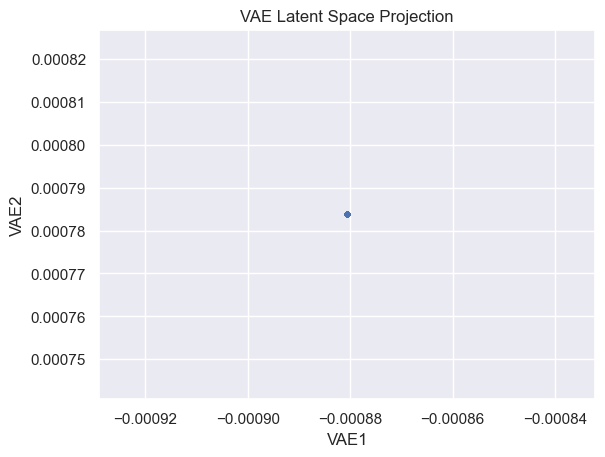

In [10]:
# Assuming you have already trained the VAE and extracted the reduced latent space
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    mu, _ = vae.encode(X_tensor)
    reduced_data = mu.cpu().numpy()  # Latent space representation (2D)

# Convert to a DataFrame for plotting
vae_df = pd.DataFrame(reduced_data, index=X_scaled.index, columns=["VAE1", "VAE2"])

# Plot the VAE results similarly to how you plotted UMAP results
sns.scatterplot(
    x="VAE1",
    y="VAE2",
    data=vae_df,
    s=15,
    alpha=0.5,
    linewidth=0.25,
    edgecolor="face"
).set_title("VAE Latent Space Projection")

plt.show()